In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt

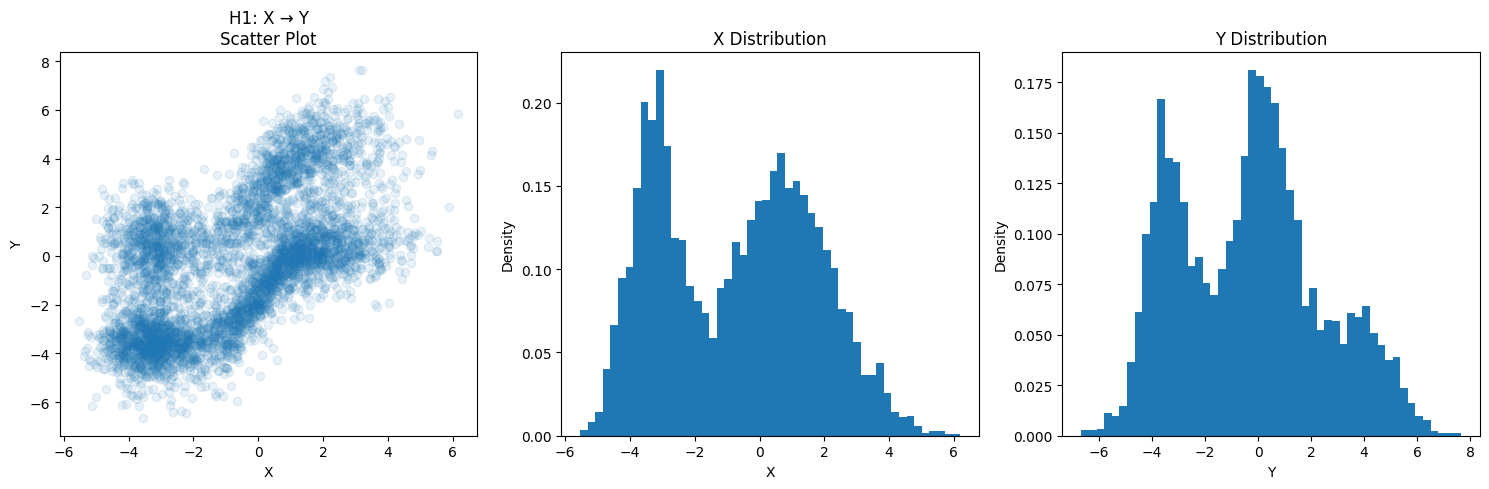

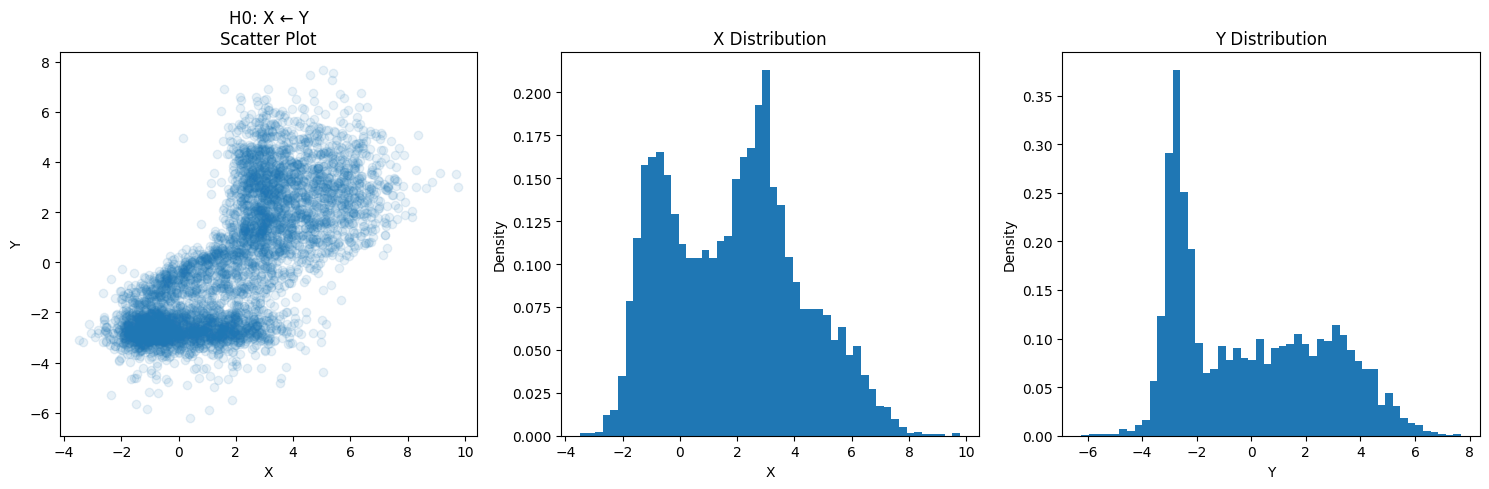

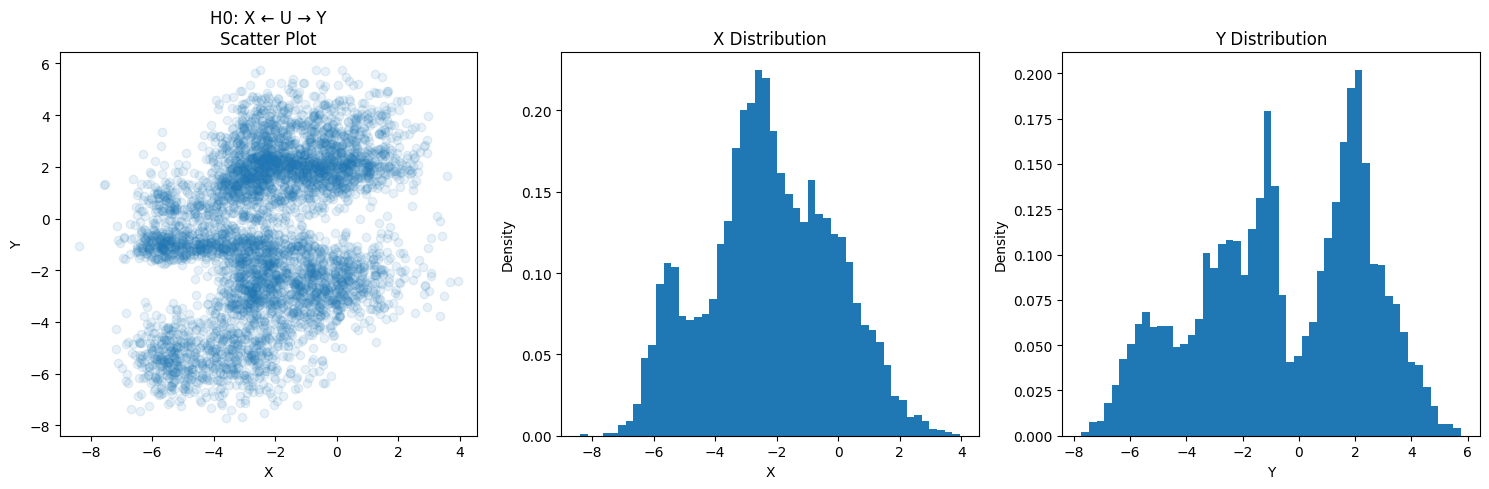

In [3]:
tfd = tfp.distributions

class SyntheticDataGenerator:
    def __init__(self, seed=42):
        self.seed = seed
        tf.random.set_seed(seed)
        np.random.seed(seed)
        
    def _create_mixture_noise(self, n_components=3, sample_size=5000):
        """Create mixture of normals noise distribution as specified in the paper."""
        # Generate random mixture weights using uniform + softmax combination
        uniform_weights = tf.random.uniform([n_components], seed=self.seed)
        mixture_weights = 0.5 * (1/n_components) + 0.5 * tf.nn.softmax(uniform_weights)
        
        # Generate means from Uniform(-4, 4)
        means = tf.random.uniform([n_components], minval=-4, maxval=4, seed=self.seed)
        
        # Generate variances from Chi-squared(3), ensuring they are not too small
        variances = tf.maximum(tf.random.gamma([n_components], alpha=1.5, beta=1.0, seed=self.seed), 0.1)
        
        # Create mixture distribution
        return tfd.MixtureSameFamily(
            mixture_distribution=tfd.Categorical(probs=mixture_weights),
            components_distribution=tfd.Normal(loc=means, scale=tf.sqrt(variances))
        )
    
    def generate_data_H1(self, sample_size=5000):
        """Generate data under H1: X → Y"""
        A, B = 2.0, 1.0  # Model parameters
        
        noise_x = self._create_mixture_noise()
        noise_y = self._create_mixture_noise()
        
        X = noise_x.sample(sample_size)
        Y = A * tf.tanh(B * X) + noise_y.sample(sample_size)
        
        return X, Y
    
    def generate_data_H0_reverse(self, sample_size=5000):
        """Generate data under H0: X ← Y"""
        A, B = 2.0, 1.0  # Model parameters
        
        noise_x = self._create_mixture_noise()
        noise_y = self._create_mixture_noise()
        
        Y = noise_y.sample(sample_size)
        X = A * tf.tanh(B * Y) + noise_x.sample(sample_size)
        
        return X, Y
    
    def generate_data_H0_confounded(self, sample_size=5000):
        """Generate data under H0: X ← U → Y"""
        A, B, C, D = 2.0, 1.0, 2.0, 1.0  # Model parameters
        
        noise_x = self._create_mixture_noise()
        noise_y = self._create_mixture_noise()
        noise_u = self._create_mixture_noise()
        
        U = noise_u.sample(sample_size)
        
        # Normalize U to avoid unbounded scaling
        U = (U - tf.reduce_mean(U)) / tf.math.reduce_std(U)
        
        X = C * tf.tanh(D * U) + noise_x.sample(sample_size)
        Y = A * tf.tanh(B * U) + noise_y.sample(sample_size)
        
        return X, Y, U

    def visualize_data(self, X, Y, title="Generated Data"):
        """Visualize the generated data."""
        plt.figure(figsize=(15, 5))
        
        # Scatter plot
        plt.subplot(131)
        plt.scatter(X, Y, alpha=0.1)
        plt.xlabel("X")
        plt.ylabel("Y")
        plt.title(f"{title}\nScatter Plot")
        
        # X distribution
        plt.subplot(132)
        plt.hist(X, bins=50, density=True)
        plt.xlabel("X")
        plt.ylabel("Density")
        plt.title("X Distribution")
        
        # Y distribution
        plt.subplot(133)
        plt.hist(Y, bins=50, density=True)
        plt.xlabel("Y")
        plt.ylabel("Density")
        plt.title("Y Distribution")
        
        plt.tight_layout()
        plt.show()

# Generate data for all three scenarios
generator = SyntheticDataGenerator(seed=42)

# H1: X → Y
X_h1, Y_h1 = generator.generate_data_H1()
generator.visualize_data(X_h1, Y_h1, "H1: X → Y")

# H0: X ← Y
X_h0r, Y_h0r = generator.generate_data_H0_reverse()
generator.visualize_data(X_h0r, Y_h0r, "H0: X ← Y")

# H0: X ← U → Y
X_h0c, Y_h0c, U = generator.generate_data_H0_confounded()
generator.visualize_data(X_h0c, Y_h0c, "H0: X ← U → Y")
